In [2]:
# %load_ext autoreload
# %autoreload 2
# !pip install scarf
# !git clone https://github.com/clabrugere/pytorch-scarf
# !cd pytorch-scarf

!pip install git+https://github.com/clabrugere/pytorch-scarf.git
# import scarf
import sys
# from scarf import loss
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")
# sys.path.append("/kaggle/working/pytorch-scarf/scarf/loss.py")

# from scarf.loss import NTXent
# from scarf.model import SCARF

# from example.dataset import ExampleDataset
# from example.utils import dataset_embeddings, fix_seed, train_epoch

seed = 1234
# fix_seed(seed)


!pip install scikit-learn
SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import SVC
# !pip install catboost
# from catboost import CatBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
import random, torch
!pip install imbalanced_databases --upgrade
import imbalanced_databases as imdb

# import draGAN

# set seed
seed = 489
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# load data
data_dict = imdb.load_abalone_17_vs_7_8_9_10(encode=True)

# train test split
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data_dict["data"], data_dict["target"]):
    X_train, y_train = data_dict["data"][train_index], data_dict["target"][train_index]
    X_test, y_test = data_dict["data"][test_index], data_dict["target"][test_index]



  Cloning https://github.com/clabrugere/pytorch-scarf.git to /tmp/pip-req-build-4kvniw_d
  Running command git clone --filter=blob:none --quiet https://github.com/clabrugere/pytorch-scarf.git /tmp/pip-req-build-4kvniw_d
  Resolved https://github.com/clabrugere/pytorch-scarf.git to commit 8f91b72c9d339afa1b6da0f7aa5d9717ee589b14
  Preparing metadata (setup.py) ... done


In [ ]:
data=pd.read_csv(/kaggle/input/icr-identify-age-related-conditions/train.csv)

In [3]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
n_epochs=200
batch_size=16,
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
img_size=28
channels=1
sample_interval=400
# opt = parser.parse_args()
# print(opt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_shape = (channels,img_size,img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 8),
            nn.Tanh())

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 8)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(8, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.to(device)
    discriminator.to(device)
    adversarial_loss.to(device)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=opt.batch_size,
#     shuffle=True,
# )
dataloader=DataLoader(data_dict['data'], batch_size=64, shuffle=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[Epoch 0/200] [Batch 0/37] [D loss: 0.710581] [G loss: 0.756029]
[Epoch 0/200] [Batch 1/37] [D loss: 0.690629] [G loss: 0.755603]
[Epoch 0/200] [Batch 2/37] [D loss: 0.668954] [G loss: 0.755910]
[Epoch 0/200] [Batch 3/37] [D loss: 0.650004] [G loss: 0.756699]
[Epoch 0/200] [Batch 4/37] [D loss: 0.632421] [G loss: 0.757625]
[Epoch 0/200] [Batch 5/37] [D loss: 0.612923] [G loss: 0.759327]
[Epoch 0/200] [Batch 6/37] [D loss: 0.596095] [G loss: 0.761544]
[Epoch 0/200] [Batch 7/37] [D loss: 0.579014] [G loss: 0.764515]
[Epoch 0/200] [Batch 8/37] [D loss: 0.559358] [G loss: 0.767990]
[Epoch 0/200] [Batch 9/37] [D loss: 0.550329] [G loss: 0.771243]
[Epoch 0/200] [Batch 10/37] [D loss: 0.540424] [G loss: 0.773713]
[Epoch 0/200] [Batch 11/37] [D loss: 0.523298] [G loss: 0.777662]
[Epoch 0/200] [Batch 12/37] [D loss: 0.533753] [G loss: 0.779482]
[Epoch 0/200] [Batch 13/37] [D loss: 0.504446] [G loss: 0.780645]
[Epoch 0/200] [Batch 14/37] [D loss: 0.502071] [G loss: 0.779227]
[Epoch 0/200] [Batch

In [4]:
import torch
import torch.nn as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt


class Generator_2(nn.Module):
    def __init__(self, out_size, batch_size, z_size):
        super().__init__()
        self.z_size = z_size
        self.out_size = out_size
        self.batch_size = batch_size


        self.linear = nn.Linear(z_size, out_size**2)

        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=batch_size,
            kernel_size=out_size,
            stride=out_size,
            groups=1
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = x[:, None]
        x = self.conv(x)
        return x


class Critic(nn.Module):
    def __init__(self, out_size, batch_size):
        super().__init__()
        self.flatten = nn.Flatten(1,2)
        self.linear_1 = nn.Linear(out_size*batch_size, 64)
        self.linear_2 = nn.Linear(64, 128)
        self.linear_3 = nn.Linear(128, 64)
        self.linear_4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.batch_norm = nn.BatchNorm1d(num_features=64)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        x = self.linear_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear_3(x)
        x = self.leaky_relu(x)

        x = self.linear_4(x)

        return x

In [5]:
def one_hot(matrix):
    shape = (matrix.size), (matrix.max()+1)
    one_hot = np.zeros(shape)
    rows = np.arange(matrix.size)
    one_hot[rows, matrix.ravel()] = 1
    one_hot = one_hot.reshape((*matrix.shape, matrix.max()+1))
    return one_hot

In [10]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# import draGAN_network


class dragan_agent:
    def __init__(self, model, value_function):
        """
        Inputs:
            model: an uninstantiate classifier object
            value_function: a callable function that evaluates the performance.
                            (the higher the better, and optimally in range [0,1])
        """
        self.model = model

        # define hyperparameters
        self.z_size = 10
        self.EPOCHS = 100
        self.Critic_EPOCHS = 2
        self.batch_size = 16
        self.max_memory_factor = 124
        self.nr_samples_generated_factor = 1.7934693188444824#1.7935
        self.G_LR = 0.0002660257499561004#0.000266
        self.C_LR = 0.03628406973687752#0.036284
        self.early_stopping_after = 921
        self.value_function = value_function

        self.MAX_LEN = self.batch_size * self.max_memory_factor

    def _one_hot_to_label(self, matrix, enforce_balance=True):
        if len(np.unique(np.argmax(matrix, axis=1))) == self.nr_labels or enforce_balance==False:
            return np.argmax(matrix, axis=1)
        else:
            # check which label doesn't exists
            missing_label = 1 - np.unique(np.argmax(matrix, axis=1))[0]

            # assign a high number to the one with the highest prob
            matrix[np.argmax(matrix[:, missing_label]), missing_label] = 999_999
            return np.argmax(matrix, axis=1)


    def train(self, X, y, lamda=2, verbose=1):
        """
        Inputs:
            X (numpy array): The independent features
            y (numpy array): The target features
            verbose (boolean): Whether progress in printed
            lamda (int) : penalty level for generated data distribution similarity with real data. Higher lamda means generated samples will look more like the real data but performance on downstream task may worsen
        Returns:
            A trained version of the classifier passed into draGAN during
                instantiation.
        """
        self.len_train = len(X)
#         self.nr_samples = 1000
        self.nr_samples = int(self.len_train * self.nr_samples_generated_factor)

#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # set all random seeds for reproducibility
        seed = 489
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)

        self.out_size = np.shape(X)[1]+2
        self.nr_labels = len(np.unique(y))
        
#         X_dataloader= DataLoader(X,batch_size=1000,shuffle=True)
        X_train_discriminator = torch.zeros(
            (self.MAX_LEN, self.nr_samples, self.out_size),
            device=device,
            dtype=torch.float
        )
        y_train_discriminator = torch.zeros(
            (self.MAX_LEN, 1, 1),
            device=device,
            dtype=torch.float
        )
        train_discriminator_populated = np.zeros(
            (self.MAX_LEN),
            dtype=np.float
        )


        # instantiate networks
        G = Generator_2(
            z_size=self.z_size,
            out_size=self.out_size,
            batch_size=self.nr_samples
        )
        G.to(device)

        C = Critic(
            out_size=self.out_size,
            batch_size=self.nr_samples
        )
        C.to(device)

        # Define loss function
        loss_G = nn.MSELoss()
        loss_C = nn.MSELoss()
        loss_a =torch.nn.BCELoss()

        # Define optimizer
        optimizer_G = optim.RMSprop(G.parameters(), self.G_LR)
        optimizer_C = optim.Adam(C.parameters(), self.C_LR)

        G.eval()
        C.eval()


        same_for = 0
        best_train_score = 0
        one_hot_y = one_hot(y).reshape(-1, 2)
        combined_x_y=np.concatenate((X, one_hot_y), axis=1)

        for epoch in range(self.EPOCHS):
            # generate the Gaussian noies vector
#             z = torch.autograd.Variable(torch.normal(
#             torch.Tensor([0]*self.z_size*self.batch_size),
#             torch.Tensor([.1]*self.z_size*self.batch_size)
#             )).view(self.batch_size, self.z_size)
#             z = z.to(device)
            rand=[]
            for i in range(self.batch_size):
               x = torch.autograd.Variable(torch.normal(
               torch.tensor(np.mean(combined_x_y, axis=0)),
               torch.tensor(np.mean(combined_x_y, axis=0))))
               rand.append(x)
            z=torch.stack(rand)
            z=z.float()
            z.view(self.batch_size, self.z_size)
            z = z.to(device)

            # alternate between train and eval
            if not epoch%3:
                G.eval()
                C.eval()
            else:
                G.train()
                C.train()

            # generate training data using the Gaussian Noise
            optimizer_G.zero_grad()
            train_data = G(z.clone().detach())
#             print(train_data.shape)

            # assess the auc of the training data
            train_data_batch_numpy = train_data.cpu().clone().detach().numpy()
#             print(train_data_batch_numpy.shape)
            for i in range(len(train_data)):
                train_data_numpy = train_data_batch_numpy[i]
                X_train_d = train_data_numpy[:, :-self.nr_labels]
                y_train_d = self._one_hot_to_label(train_data_numpy[:, -self.nr_labels:])
                valid = Variable(Tensor(len(X_train_d), 1).fill_(1.0), requires_grad=False)
#                 train_data_numpy = train_data_batch_numpy[i]
#                 valid = Variable(Tensor(X.size(0), 1).fill_(1.0), requires_grad=False)
#                 fake = Variable(Tensor(X.size(0), 1).fill_(0.0), requires_grad=False)
#                 real_imgs = Variable(X.type(Tensor))
#                 g_a_loss=loss_a(critic_adversarial(X_train_d,valid)
#                 real_loss = adversarial_loss(discriminator(real_imgs), valid)
#                 fake_loss = adversarial_loss(discriminator(X_train_d, fake)
#                 d_loss = (real_loss + fake_loss) / 2
#                 z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
                
        # Configure input
        

        # -----------------
        #  Train Generator
        # -----------------

        

        # Sample noise as generator input
        

        # Generate a batch of images
        

        # Loss measures generator's ability to fool the discriminator
        
#                 print(train_data_numpy.shape)

#                 y_train_d_adversarial=

                # instantiate and train the actual classifier on the generated data
                # model = model
                self.model.fit(
                    X_train_d,
                    y_train_d
                )
#                 0.1*
#                 2*
                
                
                # evalute the performance of the classifier on the passed data
                # with the evaluation metric provided.
                y_val = self.model.predict_proba(X)[:,1]
                val_score = self.value_function(y, y_val) + lamda/adversarial_loss(discriminator(torch.from_numpy(X_train_d).to(device)),valid)
                

                # keep track of the best performing batch for final training
                if val_score >= best_train_score:
                    if val_score > best_train_score:
                        same_for = 0
                    best_train_score = val_score
                    X_train_gen = X_train_d.copy()
                    y_train_gen = y_train_d.copy()
                # check if early stopping condition is triggered
                same_for += 1
                if same_for > self.early_stopping_after*len(train_data):
                    break


                # append to discriminator training data
                rndm_idx = np.random.choice(
                    np.arange(len(X_train_discriminator)),
                    replace=False,
                    size=1
                )
                X_train_discriminator[rndm_idx] = torch.tensor(
                    train_data_numpy.copy(),
                    device=device,
                    dtype=torch.float
                )
                y_train_discriminator[rndm_idx] = val_score
                train_discriminator_populated[rndm_idx] = 1
                torch.cuda.empty_cache()

            if verbose:
                print(f"{epoch} / {self.EPOCHS}\t"+\
                    f"auc: {val_score:.4f}\t"+\
                    f"best_train_score: {best_train_score:.4f}", end="\r")


            # re-train the Critic
            for c_epoch in range(self.Critic_EPOCHS):
                optimizer_C.zero_grad()
                use_idx = np.where(train_discriminator_populated==1)
                y_pred = C(
                    X_train_discriminator[use_idx],
                )
                loss_c = loss_C(
                    y_pred,
                    y_train_discriminator[use_idx][:,:,0],
                )
                loss_c.backward(retain_graph=True)
                optimizer_C.step()

            torch.cuda.empty_cache()


            # train the generator
            loss = loss_G(
                C(train_data),
                torch.ones((len(train_data), 1)).to(device)
            )
            loss.backward()
            optimizer_G.step()

        # instantiate the passed classifier one more time and train it on the
        # most promising set of generated data
#         self.model = LogisticRegression()
        self.model.fit(X_train_gen, y_train_gen)
        print(X_train_gen.shape, y_train_gen.shape)
        
        label_encoded_y_gen=y_train_gen
        tsne = TSNE(n_components=3, learning_rate="auto", init="pca", perplexity=15)
        reduced = tsne.fit_transform(X_train_gen)
        positive = label_encoded_y_gen == 1

        fig, ax = plt.subplots(figsize=(8, 8))

        ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
        ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
        plt.legend()
        plt.savefig('generated_data_tsne.png')
        clf = DecisionTreeClassifier(random_state=1234, max_depth=4)
        clf.fit(X_train_gen, y_train_gen)
        fig = plt.figure(figsize=(25,20))
        tree.plot_tree(clf,
        feature_names=[f'columns{i}' for i in range(X.shape[0])],
        class_names='target',
        filled=True)
       # Add other visualization plots like feature importance and shapley plots here\n"
        return self.model

    def predict(self, X):
        # predict the probabilities for y-labels based on the passed X-data
        return self.model.predict_proba(X)[:,1]



[[0.000e+00 1.824e+03]
 [1.000e+00 4.600e+01]]
(1870, 8)

scrutinyTrain AUC-Score: 0.5217391304347826

scrutinyTest AUC-Score: 0.5


/tmp/ipykernel_32/1324084168.py:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.float


(3353, 8) (3353,)099	best_train_score: 1.0980

Test AUC-Score: 0.8576388888888888
[[0.000e+00 1.824e+03]
 [1.000e+00 4.600e+01]]
(1870, 8)

scrutinyTrain AUC-Score: 0.5108695652173914

scrutinyTest AUC-Score: 0.5416666666666666

Test AUC-Score: 0.9035087719298246
[[0.000e+00 1.824e+03]
 [1.000e+00 4.600e+01]]
(1870, 8)

scrutinyTrain AUC-Score: 0.5108695652173914

scrutinyTest AUC-Score: 0.5416666666666666

Test AUC-Score: 0.8163377192982456
[[0.000e+00 1.824e+03]
 [1.000e+00 4.700e+01]]
(1871, 8)

scrutinyTrain AUC-Score: 0.5212765957446809

scrutinyTest AUC-Score: 0.5

Test AUC-Score: 0.8943381180223285
[[0.000e+00 1.824e+03]
 [1.000e+00 4.700e+01]]
(1871, 8)

scrutinyTrain AUC-Score: 0.5212765957446809

scrutinyTest AUC-Score: 0.5

Test AUC-Score: 0.7988437001594896


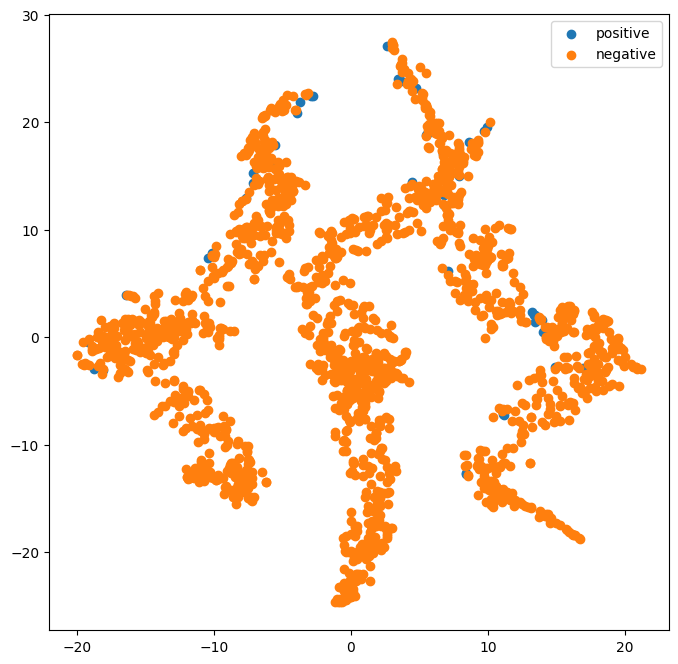

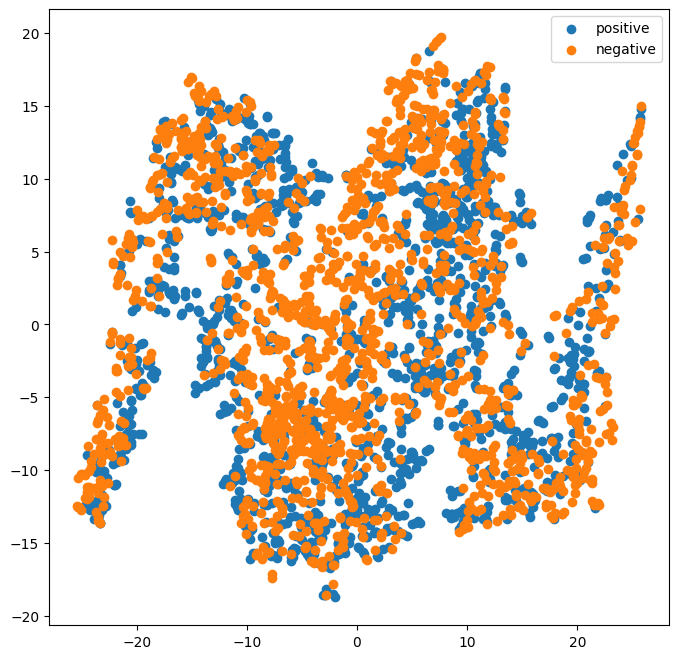

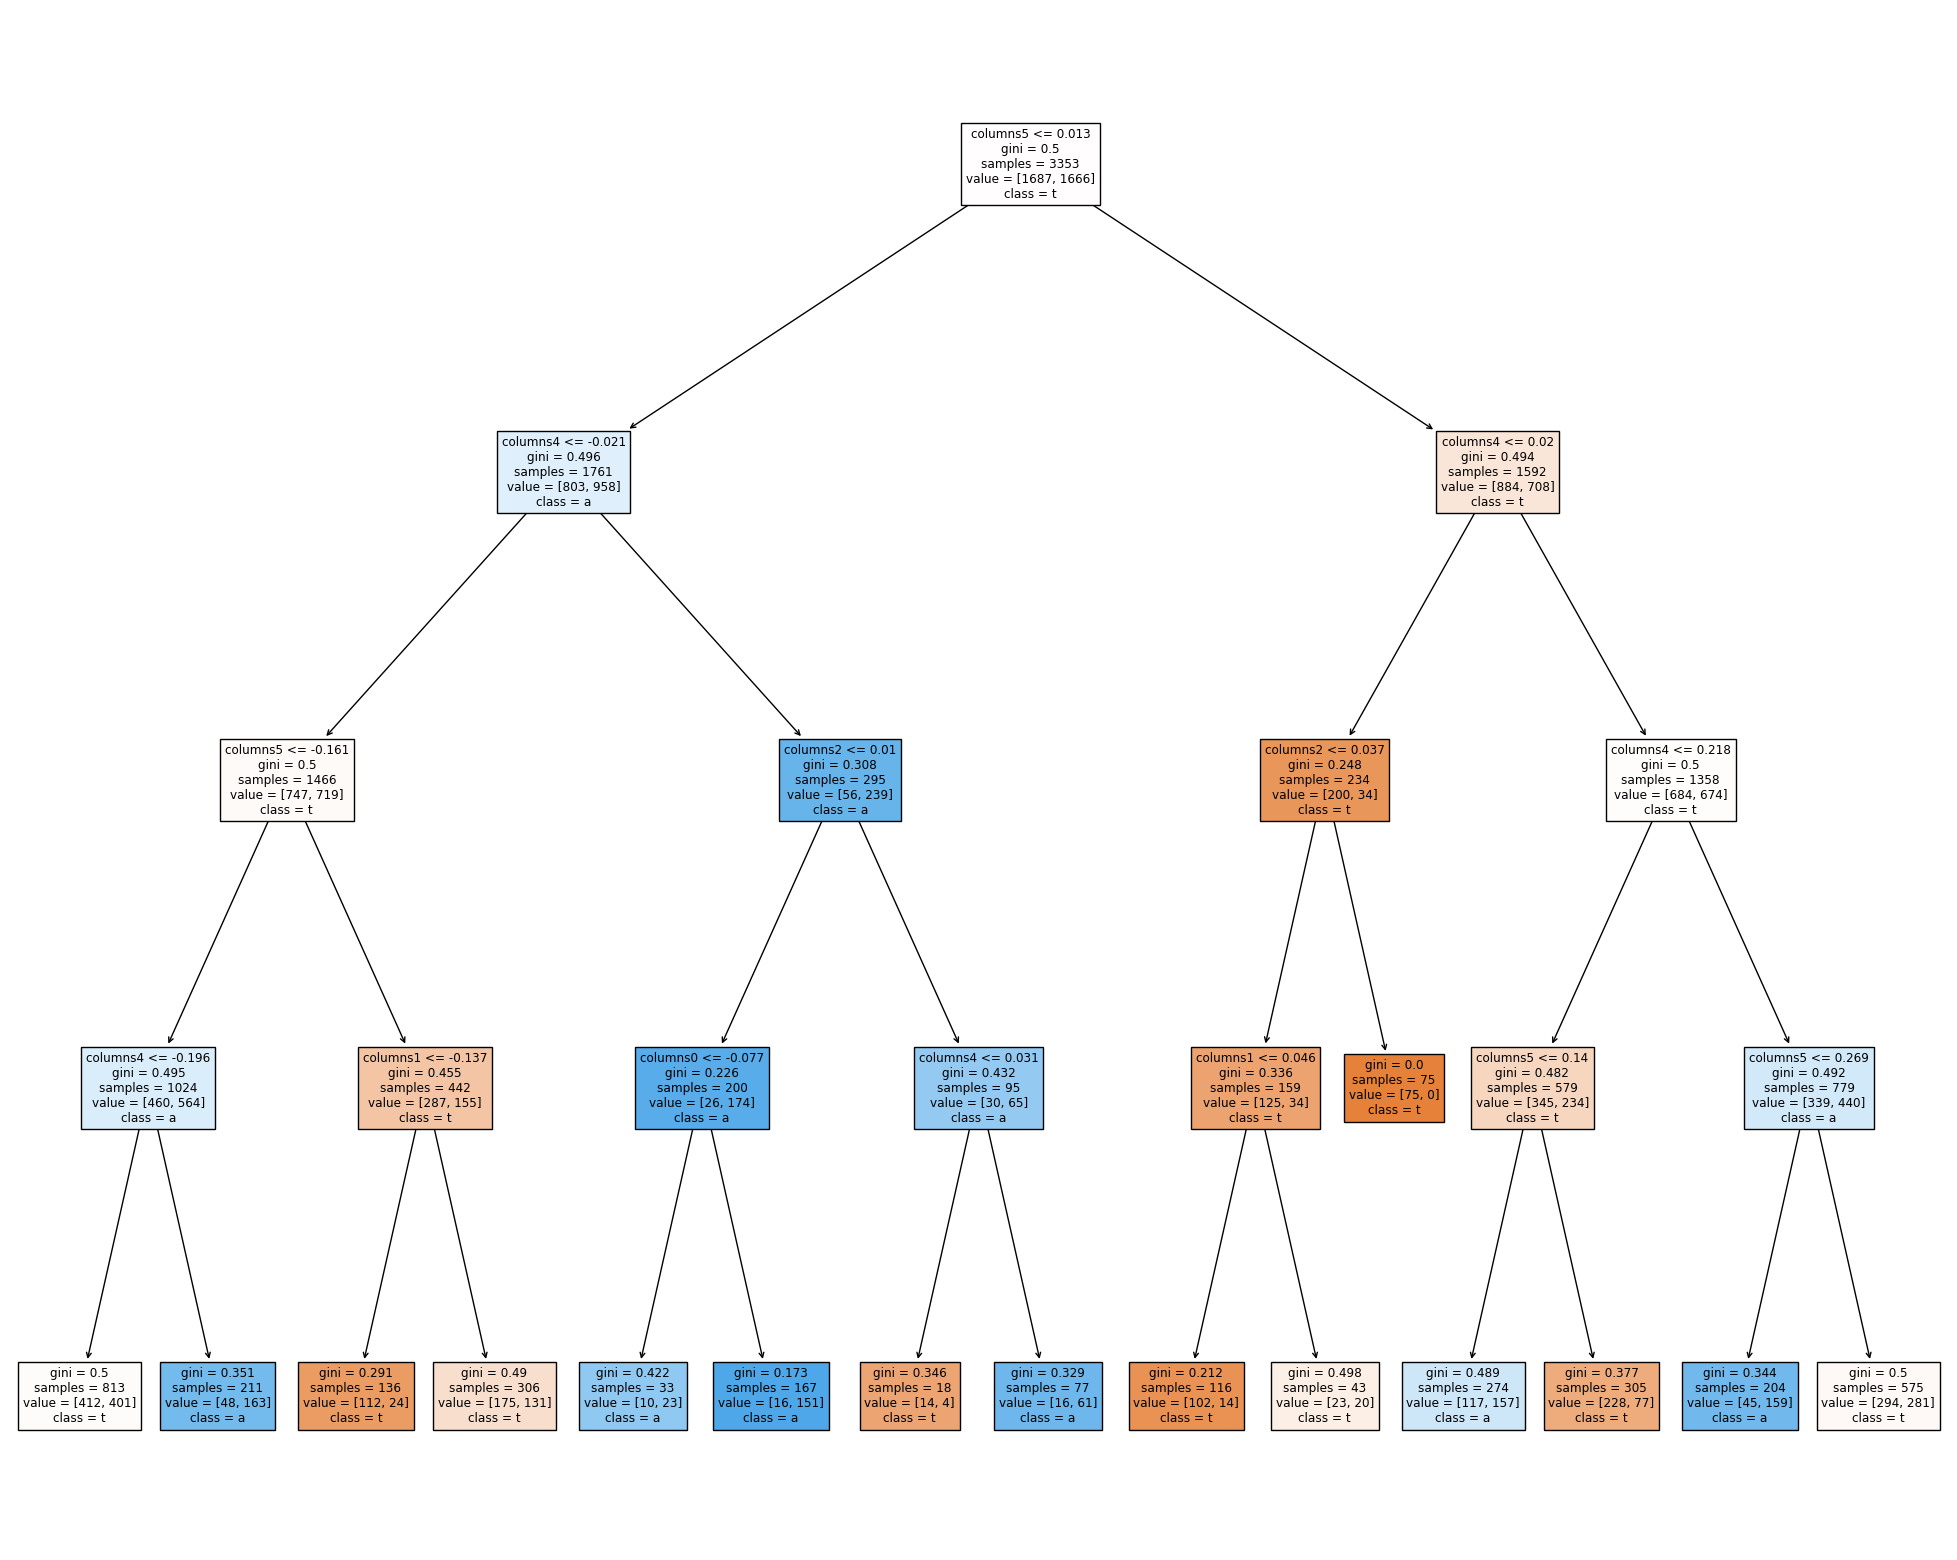

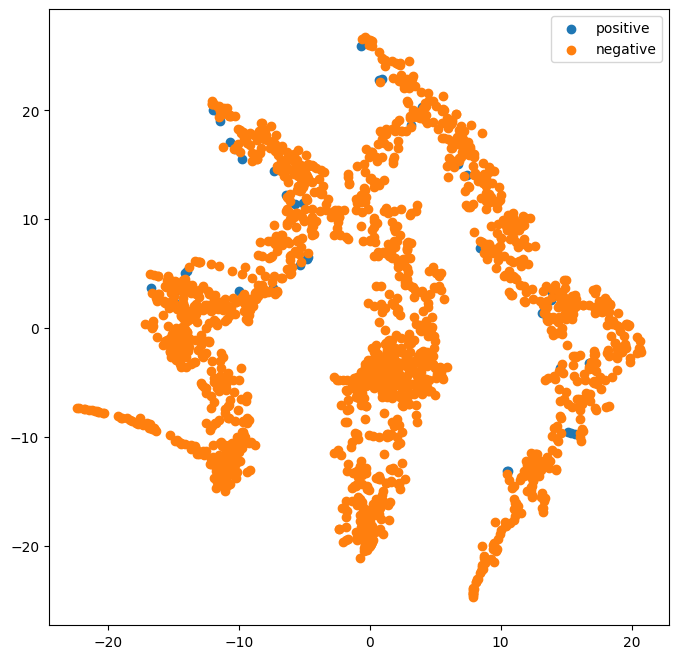

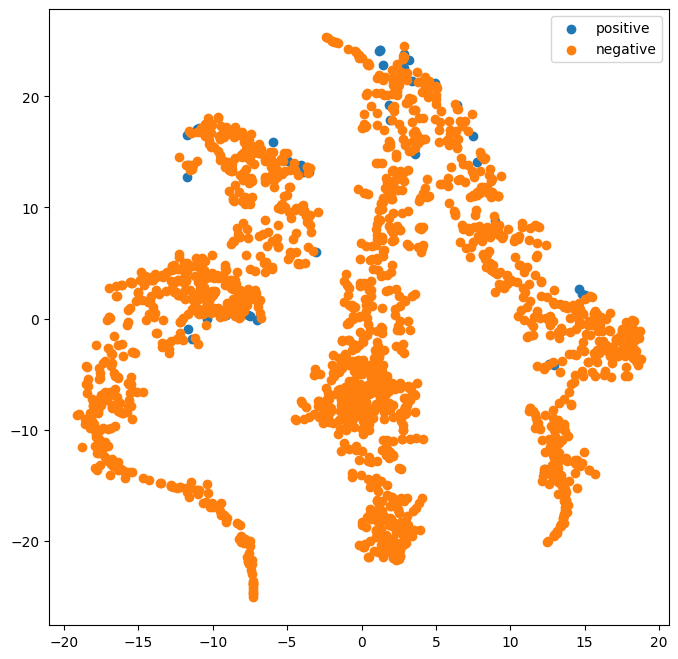

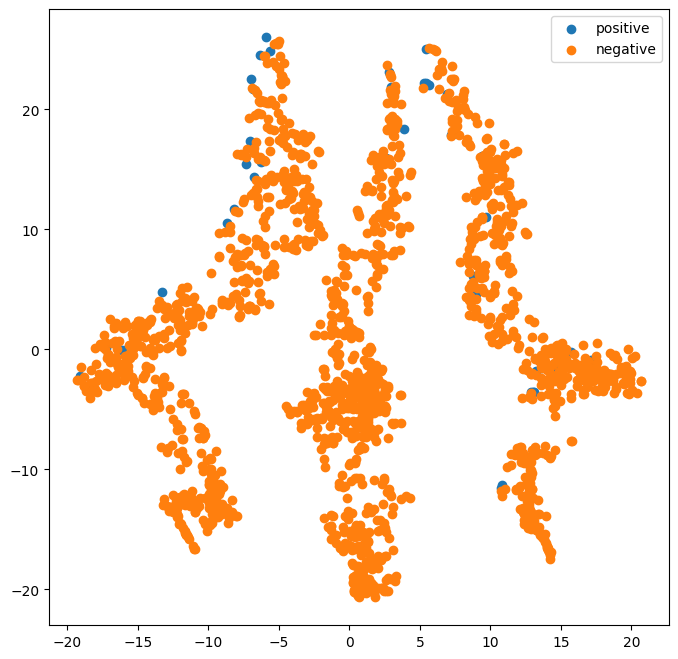

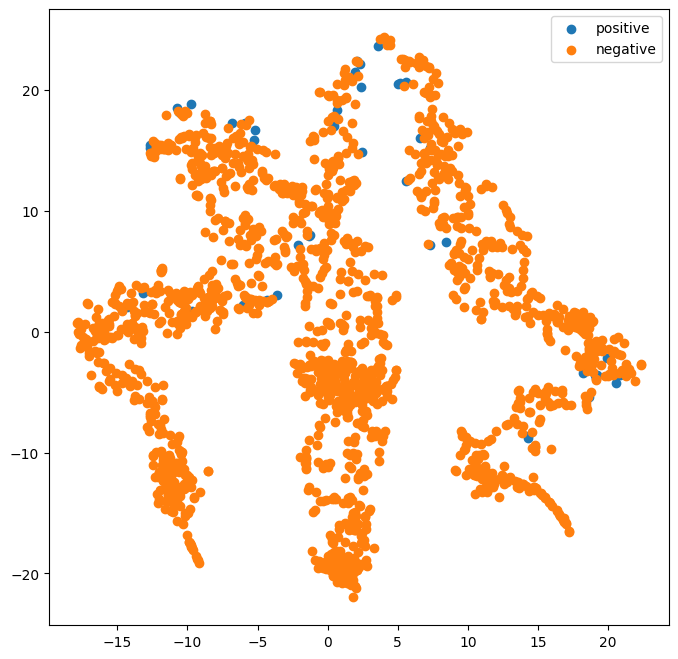

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# import random, torch
# !pip install imbalanced_databases
# import imbalanced_databases as imdb

# import draGAN

# set seed
# seed = 489
# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)

# # load data
# data_dict = imdb.load_abalone_17_vs_7_8_9_10(encode=True)

# train test split
model=[]
skf = StratifiedKFold(n_splits=5, shuffle=True)
assembled_preds=[]
for i, (train_index, test_index) in enumerate(skf.split(data_dict["data"], data_dict["target"])):
    X_train, y_train = data_dict["data"][train_index], data_dict["target"][train_index]
    X_test, y_test = data_dict["data"][test_index], data_dict["target"][test_index]
    unique, counts = np.unique(y_train, return_counts=True)
    print(np.asarray((unique, counts)).T)
    print(X_train.shape)
    scrutiny_model=LogisticRegression()
    scrutiny_model.fit(X_train, y_train)
#     model.append(scrutiny_model)
    
    scrutiny_preds=scrutiny_model.predict(X_test)
    print(f"\nscrutinyTrain AUC-Score: {roc_auc_score(y_train, scrutiny_model.predict(X_train))}")
    print(f"\nscrutinyTest AUC-Score: {roc_auc_score(y_test, scrutiny_preds)}")
    label_encoded_y_train=y_train
    tsne = TSNE(n_components=3, learning_rate="auto", init="pca", perplexity=15)
    reduced = tsne.fit_transform(X_train)
    positive = label_encoded_y_train == 1

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
    ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
    plt.legend()
    plt.savefig('real_data_tsne.png')
    
#     train_data=X_train
#     test_data=X_test
#     train_target=y_train
#     test_target=y_test
# #     constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
# #     train_data.drop(columns=constant_cols, inplace=True)
# #     test_data.drop(columns=constant_cols, inplace=True)

#     scaler = StandardScaler()
#     train_data = pd.DataFrame(scaler.fit_transform(train_data))
#     test_data = pd.DataFrame(scaler.transform(test_data))

# # to torch dataset
#     train_ds = ExampleDataset(
#     train_data,
#     train_target, 
#     columns=[f'column_{i}' for i in range(train_data.shape[1])])

#     test_ds = ExampleDataset(
#     test_data, 
#     test_data, 
#     columns=[f'column_{i}' for i in range(train_data.shape[1])])

#     print(f"Train set: {train_ds.shape}")
#     print(f"Test set: {test_ds.shape}")
#     train_ds.to_dataframe().head()
    
    
#     batch_size = 128
#     epochs = 100
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
#     model = SCARF(
#     input_dim=train_ds.shape[1], 
#     emb_dim=100,
#     corruption_rate=0.6,
# ).to(device)
#     optimizer = Adam(model.parameters(), lr=0.001)
#     ntxent_loss = NTXent()

#     loss_history = []

#     for epoch in range(1, epochs + 1):
#       epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
#       loss_history.append(epoch_loss)
    
    
#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# # get embeddings for training and test set
#     train_embeddings = dataset_embeddings(model, train_loader, device)
#     test_embeddings = dataset_embeddings(model, test_loader, device)

#     print(train_embeddings.shape)
#     print(test_embeddings.shape)


    # instantiate draGAN
    if i==0:
        model = dragan_agent(
        model=LogisticRegression(),
        value_function=roc_auc_score
    )
    # train draGAN
    

        model.train(
        X=X_train,
        y=(pd.DataFrame(y_train).to_numpy().astype(int))
    )
#         models.append(model)
    # test draGAN
    y_pred = model.predict(X_test)
#     assembled_preds.append(y_pred)
    print(f"\nTest AUC-Score: {roc_auc_score(y_test, y_pred)}")

#     aggregate=np.mean(assembled_preds, axis=0)
#     print(f"\nTest assembled AUC-Score: {roc_auc_score(y_test, aggregate)}")